# Setup

In [19]:
import pandas as pd
import os
import numpy as np
from scipy import stats
from collections import Counter, defaultdict
from statistics import mean
import random
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import timedelta
import pickle
import json
import timeit
import warnings
import itertools
import gc

In [7]:
sns.set_theme(style="ticks", color_codes=True)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
# Use glicko-2 implementation by Ryan Kirkman
!git clone https://github.com/ryankirkman/pyglicko2

Cloning into 'pyglicko2'...


In [10]:
cd pyglicko2

C:\Users\igisb\Documents\GitHub\pairwise_ranking\pyglicko2


In [11]:
import glicko2

### Example 

In [17]:
# Test to see if everything's working (code from pyglicko2 repository)

def exampleCase():
    # Create a player called Ryan
    Ryan = glicko2.Player()
    print("Old Rating Deviation: " + str(Ryan.rd))
    print("Old Volatility: " + str(Ryan.vol))
    Ryan.update_player([x for x in [1400, 1550, 1700]],
        [x for x in [30, 100, 300]], [1, 0, 0])
    print("New Rating: " + str(Ryan.rating))
    print("New Rating Deviation: " + str(Ryan.rd))
    print("New Volatility: " + str(Ryan.vol))

def timingExample(runs = 10000):
    timeTaken = timeit.Timer("Ryan = glicko2.Player(); \
                             Ryan.update_player([x \
    for x in [1400, 1550, 1700]], \
    [x for x in [30, 100, 300]], [1, 0, 0])", \
        "import glicko2").repeat(1, 10000)
    print("\nThe time taken to perform " + str(runs), "separate calculations (in seconds) was:", round(timeTaken[0], 4))

In [18]:
exampleCase()
timingExample()

Old Rating Deviation: 350.0
Old Volatility: 0.06
New Rating: 1441.5327915010964
New Rating Deviation: 193.22832145690708
New Volatility: 0.05999342346059785

The time taken to perform 10000 separate calculations (in seconds) was: 0.4432


### Sample players

In [20]:
# Assume we have 1000 chess players and want to determine their ranking
# We'll need to have them play matches against each other and each match will result in a w/d/l
# Players' ranking score will change after each tournament
# I'm interested in pairwise text comparisons - so the players will be texts, and their match will be a research participant reading both texts and deciding which text is more difficult (i.e., which text wins)

# Set variables: number of players (=number of texts), and expected distribution of player strength
# s => distribution (mean: 1500, stdev: 300, n: number of players)
text_n = 1000
s = np.random.normal(1500, 300, text_n)

# Sample datapoints
# Tuple consisting of (text id, true rating, and glicko object)
objs = [(ti, tr, glicko2.Player()) for ti, tr in zip(range(text_n), s)]

In [25]:
def glicko_test(text_n, s, total_participants, comparison_per_participant, stratnum):
    """
    
    """
    objs = [(ti, tr, glicko2.Player()) for ti, tr in zip(range(text_n), s)]

    # Define comparison number and epochs (the number of times the entire data set will be used)
    total_comparisons = total_participants * comparison_per_participant
    epochs = int(total_comparisons / text_n)
    print(f'Total comparison num: {total_comparisons}')
    print(f'Stratnum: {stratnum}')

    # Measure time
    time_start = time.time()
    for _ in range(epochs):
        # Stratification (sort by current rating and divide into different groups of set number (stratnum))
        objs_sort = sorted(objs, key=lambda x: x[2].rating)
        objs_sort = list(np.split(np.array(objs_sort), stratnum))
        # Iterate through divisions
        for play in objs_sort:
            random.shuffle(play)
            while len(play) != 0:
                player1 = play[0]
                player2 = play[1]
                # If player 1 (i.e., text 1) wins
                if player1[1] > player2[1]:
                    player1 = player1[2]
                    player2 = player2[2]
                    saverate = player1.rating
                    savedev = player1.rd
                    player1.update_player([player2.rating], [player2.rd], [1])
                    player2.update_player([saverate], [savedev], [0])
                # If player 2 wins
                else:
                    player1 = player1[2]
                    player2 = player2[2]
                    saverate = player2.rating
                    savedev = player2.rd
                    player2.update_player([player1.rating], [player1.rd], [1])
                    player1.update_player([saverate], [savedev], [0])
                play = play[2:]
    time_end = time.time()

    mae = mean([abs(w[1] - w[2].rating) for w in objs])
    print(f'Mean absolute error: {mae}')
    print(f"Elapsed time: {round(time_end - time_start, 5)} seconds")
    sns.histplot([w[2].rating for w in objs], kde=True);
    plt.show()

    return objs

Total comparison num: 100000
Stratnum: 20
Mean absolute error: 42.50609826926509
Elapsed time: 3.20042 seconds


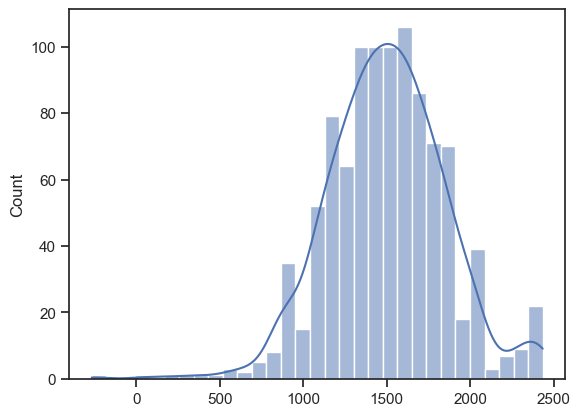

In [26]:
# Try with 20 divisions
glickres20 = glicko_test(1000, s, 1000, 100, 20)